# kNN Image Classifier
### Importing Libraries And Data

In [31]:
## importing necessary libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from cs231n.data_utils import load_CIFAR10

In [32]:
## loading data from tensorflow datasets
# cifar = tf.keras.datasets.cifar10
# (x_train, y_train), (x_test, y_test) = cifar.load_data()

## loading data from cifar-10 batch
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)

## printing shapes of data as a sanity checks
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visualizing CIFAR-10 Dataset

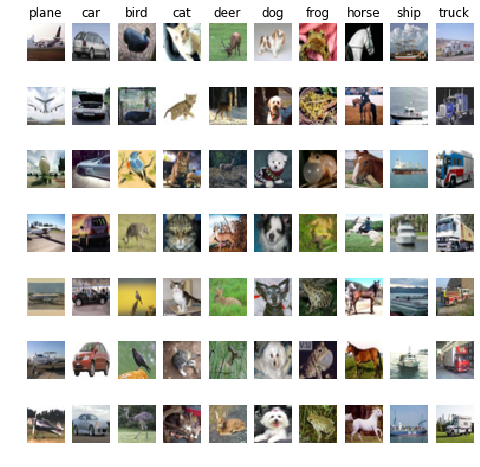

In [33]:
## Visualizing some examples from the dataset 

## our settings for this plot
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_classes = 7
plt.figure(figsize=(8,8))

for y, cls in enumerate(classes):
    ## returns the indexes of examples which belong to class y
    idxs = np.flatnonzero(y_train == y)
    ## selecting 'samples_per_classes' random indexes from idxs array
    idxs = np.random.choice(idxs, samples_per_classes, replace = False)
    
    ## prining selected examples from class 'y'
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_classes, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if (i==0):
            plt.title(cls)
plt.show()

### Subsampling Data For Efficient Execution And Reshaping Arrays<br>

In [34]:
## size of data
num_training = 5000
num_test = 500

## masking for the training data
mask = list(range(num_training))
x_train = x_train[mask]
y_train = y_train[mask]

## masking for the test data
mask = list(range(num_test))
x_test = x_test[mask]
y_test = y_test[mask]

## printing shapes of data as a sanity checks
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (5000, 32, 32, 3)
Training labels shape:  (5000,)
Test data shape:  (500, 32, 32, 3)
Test labels shape:  (500,)


In [35]:
## reshaping arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

## prining shapes as a sanity checks
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (5000, 3072)
Test data shape:  (500, 3072)


### kNN Classifier <br>

In [36]:
class kNearestNeighbour:
    
    
    def __init__(self):
        pass
    
    def train(self, x, y):
        ## nothing happens in this function basically
        ## all the work in kNN happens during testing
        
        self.x_train = x
        self.y_train = y
        
        
    def predict(self, x, k = 1, num_loops = 0):
        ## predict labels for test data using this classifier
        
        ## x: the training data
        ## k: the number of nearest neighbours that vote for the predictions
        ## num_loops: if you vectorized implementation or loops
        
        if num_loops == 0:
            dists = self.compute_distances_no_loops(x)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(x)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(x)
        else:
            raise ValueError('Invalid value of {} for num_loops'.format(num_loops))
        
        return self.predict_labels(dists, k = k)
    
    def compute_distances_two_loops(self, x):
        
        ## compute distances using two nested loops over both test and training data
        
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        
        for i in range(num_test):
            for j in range(num_train):
                
                dists[i, j] = np.linalg.norm(self.x_train[j] - x[i])
        
        return dists
    
    def compute_distances_one_loop(self, x):
        
        ## compute distances using a loop over test data
        
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        
        for i in range(num_test):
            
            dists[i, :] = np.linalg.norm((self.x_train - x[i]), axis = -1)
        
        return dists
    
    def compute_distances_no_loops(self, x):
        
        ## computing distances using no loopsss at all -- total vectorization
        
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        
        ## so we are calculating L2 distances with 100% vectorization. This might be typical to understand.
        ## we are making use of [[ (a-b)^2 = a^2 + b^2 - 2*a*b ]] to calculate L2 distances.
        dists = np.sqrt( np.sum(x**2, axis = 1).reshape(num_test, 1)  +   np.sum(self.x_train**2, axis = 1).reshape(1, num_train)  -  2*np.dot(x, self.x_train.transpose()))             
        
        return dists
    
    def predict_labels(self, dists, k = 1):
        
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        
        for i in range(num_test):
            
            ## np.argsort() returns the indexes of smallest elements
            top_k_indx = np.argsort(dists[i])[:k]
            closest_y = (self.y_train[top_k_indx])
            
            ## to remove any single dimensions
            closest_y = closest_y.squeeze()
            closest_y = closest_y.tolist()
            
            ## now we have labels of all the closest_y, now we want to find the most common amongst them
            ## it means that array has only 1 element because np.squeeze has been used

            if isinstance(closest_y, int) == True:
                ## nearest neighbour case
                label = closest_y
            else:
                ## k nearest neighbour case
                myset = list(set(closest_y))
                freq = [closest_y.count(x) for x in myset]
                index_of_max_freq = freq.index(max(freq))
                label = myset[index_of_max_freq]
            
            y_pred[i] = label
            
        return y_pred

## making a kNearestNeighbour Class
classifier = kNearestNeighbour()
classifier.train(x_train, y_train)

### Compute Distances_Two_Loops

In [37]:
## testing
distances = classifier.compute_distances_two_loops(x_test)
print(distances.shape)

(500, 5000)


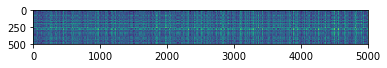

In [38]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(distances, interpolation = 'none')
plt.show()

In [39]:
## Implementing function predict_labels
## Using k = 1 (which is same as nearest neighbours)
y_test_pred = classifier.predict_labels(distances, k = 1)

## computing accuracy

num_correct = np.sum(y_test_pred == y_test.squeeze())
accuracy = num_correct / num_test
print('Got {} / {} correct => Accuracy: {}'.format(num_correct, num_test, accuracy))

Got 137 / 500 correct => Accuracy: 0.274


In [40]:
## now using kNN's main feature and set k = 5
y_test_pred = classifier.predict_labels(distances, k = 5)



## computing accuracy
num_correct = np.sum(y_test_pred == y_test.squeeze())
accuracy = num_correct/num_test
print('Got {} / {} correct => Accuracy: {}'.format(num_correct, num_test, accuracy))

Got 139 / 500 correct => Accuracy: 0.278


### Compute Distances_One_Loop

In [41]:
## using semi vectorized implementation
distances_one = classifier.compute_distances_one_loop(x_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

difference = np.linalg.norm(distances - distances_one, ord='fro')
print('Difference was {}'.format(difference, ))

if difference < 0.001:
    print('The distance matrices are same')
else:
    print('The distance matrices are not same')

Difference was 0.0
The distance matrices are same


### Compute Distances_No_Loops || Fully Vectorized

In [42]:
## using no loops this time
distances_vec = classifier.compute_distances_no_loops(x_test)

## checking if there's any difference in the naive and vectorized generated matrices
difference = np.linalg.norm(distances - distances_vec, ord='fro')
print('Difference was {}'.format(difference, ))

if difference < 0.001:
    print('The distance matrices are same')
else:
    print('The distance matrices are not same')

Difference was 0.0
The distance matrices are same


### Comparing Time Taken By Each Method

In [43]:
## comparing how fast the implementations are
def time_function(f, *args):
    
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc-tic

two_loop_time = time_function(classifier.compute_distances_two_loops, x_test)
print('Two loop version took {} seconds'.format(two_loop_time))

one_loop_time = time_function(classifier.compute_distances_one_loop, x_test)
print('One loop version took {} seconds'.format(one_loop_time))

no_loop_time = time_function(classifier.compute_distances_no_loops, x_test)
print('No loop version took {} seconds'.format(no_loop_time))

## vector implementation should be significantly faster

Two loop version took 33.54318857192993 seconds
One loop version took 82.50526642799377 seconds
No loop version took 0.6616373062133789 seconds


### Cross Validation

We implemented kNN but we set the value of k pretty much arbitirarily. We'll now use cross validation to find a nice value of k.

In [47]:
## we are going to implement k fold cross validation and so we'll set num_folds
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

x_train_folds = []
y_train_folds = []

# Split up the training data into folds. After splitting, x_train_folds and    
# y_train_folds should each be lists of length num_folds, where                
# y_train_folds[i] is the label vector for the points in x_train_folds[i].

x_train_folds = np.split(x_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.

k_to_accuracies = {}
num_split = x_train.shape[0] / num_folds
acc_k = np.zeros((len(k_choices), num_folds), dtype = np.float)

# Perform k-fold cross validation to find the best value of k. For each     
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   
# where in each case you use all but one of the folds as training data and the 
# last fold as a validation set. Store the accuracies for all fold and all     
# values of k in the k_to_accuracies dictionary.

for ik, k in enumerate(k_choices):
    for i in range(num_folds):
        train_set = np.concatenate((x_train_folds[:i] + x_train_folds[i+1:]))
        label_set = np.concatenate((y_train_folds[:i] + y_train_folds[i+1:]))
        classifier.train(train_set, label_set)
        y_pred_fold = classifier.predict(x_train_folds[i], k=k, num_loops = 0)
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        acc_k[ik, i] = num_correct/num_split
    k_to_accuracies[k] = acc_k[ik]
    
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print("k = {} , accuracy = {}".format(k, accuracy))

k = 1 , accuracy = 0.263
k = 1 , accuracy = 0.257
k = 1 , accuracy = 0.264
k = 1 , accuracy = 0.278
k = 1 , accuracy = 0.266
k = 3 , accuracy = 0.241
k = 3 , accuracy = 0.249
k = 3 , accuracy = 0.243
k = 3 , accuracy = 0.273
k = 3 , accuracy = 0.264
k = 5 , accuracy = 0.256
k = 5 , accuracy = 0.271
k = 5 , accuracy = 0.28
k = 5 , accuracy = 0.289
k = 5 , accuracy = 0.278
k = 8 , accuracy = 0.263
k = 8 , accuracy = 0.287
k = 8 , accuracy = 0.276
k = 8 , accuracy = 0.288
k = 8 , accuracy = 0.27
k = 10 , accuracy = 0.266
k = 10 , accuracy = 0.296
k = 10 , accuracy = 0.279
k = 10 , accuracy = 0.283
k = 10 , accuracy = 0.283
k = 12 , accuracy = 0.261
k = 12 , accuracy = 0.294
k = 12 , accuracy = 0.28
k = 12 , accuracy = 0.283
k = 12 , accuracy = 0.28
k = 15 , accuracy = 0.253
k = 15 , accuracy = 0.29
k = 15 , accuracy = 0.279
k = 15 , accuracy = 0.28
k = 15 , accuracy = 0.275
k = 20 , accuracy = 0.27
k = 20 , accuracy = 0.279
k = 20 , accuracy = 0.279
k = 20 , accuracy = 0.28
k = 20 , accur

### Plotting the observations

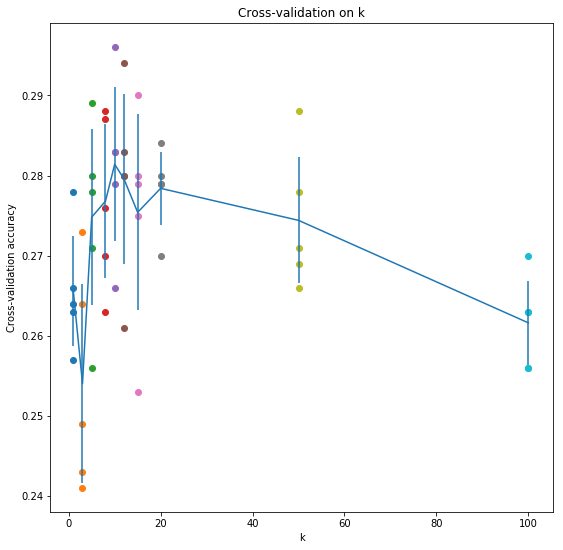

In [55]:
# plot the raw observations
plt.figure(figsize = (9,9))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [66]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = kNearestNeighbour()
classifier.train(x_train, y_train)
y_test_pred = classifier.predict(x_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
